# Planejamento da Solução

## Input

1. Problema de negócio
 - Selecionar os clientes mais valiosos para criar um programa de fidelidade
2. Conjunto de dados
 - Vendas de e-commerce no período de um ano

## Output

1. <b>Indicação das pessoas que farão parte do programa de fidelidade
    - Tabela com: <br>
            |customer_id | is_insider| 
            |    1      |     yes   | 
            |    2      |     no    | 
 
2. <b>Responder as perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior valor?
    - Faturamento:
        - Alto Ticket médio
        - Alto LTV
        - Baixa recência (compra mais frequentemente)
        - Alto basket size (tamanho de cesta)
        - Baixa probabilidade de churn (periodo que passa e não vai mais comprar)
        - Alta previsão de LTV
        - Alta propensão de compra
    - Custo:
        - Baixa taxa de devolução
    - Experiência de compra:
        - Alta média das avaliações
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders
    
    
3. Quais as principais características desses clientes ?
    - Escrever características do cliente (podem ser utilizadas para busca clientes semelhantes)
        - Idade
        - Localização
    - Escrever caacterísticas do consumo
        - Atributos da clusterização
        
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort (como um grupo de pessoas se comporta ao longo do tempo)
        - Sabendo que pessoas que compram calça na primeira compram geram maior faturamento futuro, posso otimizar campanhas
        - Pessoas da localidade X trazem maior faturamento 
    

6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a perodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar com uma pessoa do grupo
    

7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a perodicidade (1 mes, 3 meses)
    - A pessoa precisa ser não parecida com uma pessoa do grupo (começa a se distanciar do cluster)


8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete
    - Visita a empresa


# 0.0. IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import plotly.express as px

from matplotlib import pyplot as plt
from IPython.display import HTML
from matplotlib import cm

from inflection import underscore
import pickle
import re

In [2]:
from pandas_profiling import ProfileReport

In [2]:
from sklearn import preprocessing as pp
# PCA
from sklearn import decomposition as dd
# TSNE
from sklearn.manifold import TSNE

In [3]:
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics as m
from sklearn import ensemble as en

In [4]:
import umap.umap_ as ump

## 0.1. Helper Functions

In [5]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container { width:95% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows=50
    pd.set_option('display.expand_frame_repr', False)
       
    sns.set()
    
jupyter_settings()

## 0.2. Loading Data

In [7]:
data_raw = pd.read_csv('../datasets/Ecommerce.csv',encoding='latin-1')
data_raw.drop(columns=['Unnamed: 8'], inplace=True)

# 1.0. PASSO 01 - DATA DESCRIPTION

In [8]:
df1 = data_raw.copy()
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Rename Columns

In [9]:
df1.columns = df1.columns.to_series().apply(underscore)

## 1.2. Data Dimensions

In [10]:
print(f'Counting {df1.shape[0]} rows and {df1.shape[1]} columns')

Counting 541909 rows and 8 columns


## 1.3. Data Types

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Fillout NA's

In [13]:
df_missing = df1.loc[df1['customer_id'].isna()]
df_missing.shape

(135080, 8)

In [14]:
df_not_missing = df1.loc[~df1['customer_id'].isna()]
df_not_missing.shape

(406829, 8)

In [15]:
# looking for invoice_no with missing customer_id in df_not_missing
list_of_invoice_missing = list(df_missing['invoice_no'].unique())
df_not_missing[df_not_missing['invoice_no'].isin(list_of_invoice_missing)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [16]:
# Feito--> Preencher os customer_id's com id's a partir de 19000 (linhas com o mesmo invoice_no são do mesmo customer_id)
df_for_fill_customer = pd.DataFrame({'invoice_no':list_of_invoice_missing})
df_for_fill_customer['customer_id'] = df_for_fill_customer.index+19000

df_missing = df_missing.merge(df_for_fill_customer, on='invoice_no', how='left', 
                             suffixes=('_delete','')).drop(columns=['customer_id_delete'])

df1 = pd.concat([df_not_missing, df_missing]).reset_index(drop=True)


# # outro método --> faz o merge do df1 e do df_for_fill_customer e depois usa o coalesce :
# df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id'_y])

In [17]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
customer_id        0
country            0
dtype: int64

## 1.6. Verifying Types

In [18]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id 
df1['customer_id'] = df1['customer_id'].astype('int64')

df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7. Descriptive Statistics

In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [20]:
df_num_attibutes = num_attributes.describe()

df_num_attibutes.loc['kurtosis',] = num_attributes.describe().kurtosis().values
df_num_attibutes.loc['skew'] = num_attributes.describe().skew().values

df_num_attibutes = df_num_attibutes.T

df_num_attibutes['range'] = df_num_attibutes['max'] - df_num_attibutes['min']

df_num_attibutes = df_num_attibutes[['min', 'max', 'range', 'mean' , '50%', 'std', 
                  'skew', 'kurtosis']].reset_index().rename(columns={'index': 'attribute', '50%': 'median'})

df_num_attibutes

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.081158,2.557763,6.880051
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759853,2.795606,7.854019
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.411352,2.823097,7.977626


#### 1.7.1. Numerical Attributes - Looking for errors

1. Quantity negativo --> Pode ser devolução

2. unit_price igual a 0 --> promoção? 

In [21]:
# quantity < 0 --> aparenta ser devolução/descontos/etc --> separar entre compras e retornos
print(f"{df1[df1['quantity'] <0].count().values[0]} rows with quantity < 0")

# unit_price == 0 --> nao vi razão aparente, então vou considerar com erro e deleta-las
print(f"{df1[df1['unit_price'] ==0].count().values[0]} rows with unit_price = 0 --> will be deleted")

10624 rows with quantity < 0
2515 rows with unit_price = 0 --> will be deleted


### 1.7.1. Categorical Attributes

In [22]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### invoice no

In [23]:
# invoice no
letter_index_invoice = cat_attributes['invoice_no'].apply(lambda x: True if re.search('[A-Za-z]',x) != None else False)
print(f"{len(cat_attributes.loc[letter_index_invoice, 'invoice_no'])} rows invoice_no with letters")
print(f"{len(cat_attributes.loc[letter_index_invoice, 'invoice_no'].unique())} unique invoice_no with letters")

9291 rows invoice_no with letters
3839 unique invoice_no with letters


#### stock code

In [24]:
# stock code
only_letters_stock = cat_attributes['stock_code'].apply(lambda x: True if re.search('^[A-Z a-z]+$',x) != None else False)
print(list(cat_attributes.loc[only_letters_stock,'stock_code'].unique()))

# Ação --> Por enquanto retirar ['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT',
# 'CRUK', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'B'] --> não vou considerar compras

['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'B']


In [25]:
at_least_oneletter_stock = cat_attributes['stock_code'].apply(lambda x: True if re.search('[A-Za-z]',x) != None else False)
print(f"{len(cat_attributes.loc[at_least_oneletter_stock, 'stock_code'].unique())} unique stock_code with letters\n")
print(f"{cat_attributes.loc[at_least_oneletter_stock, 'stock_code'].sample(5).values} ...")

1124 unique stock_code with letters

['85034B' '85123A' '72349B' '85131D' 'POST'] ...


#### description

In [26]:
# Ação --> Deletar description

#### country

In [27]:
# Ação --> Deletar European Community e Unspecified
# Todo --> Tentar alterar os nomes 
cat_attributes['country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

# 2.0. PASSO 02 - FILTRAGEM DE VARIÁVEIS

In [28]:
df2 = df1.copy()

In [29]:
### Removing Customers ###
df2 = df2[~df2['customer_id'].isin([12346, 16446])] # praticamente devolveu tudo que comprou + de 70_000 produtos 

In [30]:
### Categorical Attibutes ###
# stock code != ['POST', 'D', 'M', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK', 
                                   'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'B'])]

# description
df2 = df2.drop(columns=['description'])

# country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

In [31]:
### Numerical Attibutes ###

# unit_price
# df2.loc[df2['unit_price'] > 0.01, :].sort_values('unit_price', ascending=True)
df2 = df2.loc[df2['unit_price'] > 0.01, :]

# quantity
df_purchases = df2.loc[df2['quantity'] > 0]
df_returns = df2.loc[df2['quantity'] < 0]

# 3.0. PASSO 03 - FEATURE ENGINEERING

In [32]:
df3 = df2.copy()

## 3.1. Feature Engineering

In [33]:
# creating a reference dataframe --> only id's
df_reference = df3[['customer_id']].drop_duplicates(ignore_index=True)

### 3.1.1. Revenue

In [34]:
# Revenue --> Faturamento --> Quantity * Price
df_purchases.loc[:, 'revenue'] = (df_purchases['quantity'] * df_purchases['unit_price'])
revenue_per_client = df_purchases[['customer_id', 'revenue']].groupby('customer_id').sum()
df_reference = df_reference.merge(revenue_per_client, on='customer_id', how='left')

C:\Users\Miguel\AppData\Local\Temp\ipykernel_8656\2578962312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchases.loc[:, 'revenue'] = (df_purchases['quantity'] * df_purchases['unit_price'])


### 3.1.2. Recency

In [35]:
# Recency --> Today - Last day purchase
last_buy_date_per_client = df_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_reference = df_reference.merge(last_buy_date_per_client, on='customer_id', how='left').rename(columns={'invoice_date': 'recency'})
df_reference['recency'] = (df_purchases['invoice_date'].max() - df_reference['recency']).dt.days

### 3.1.3. Quantity of orders

In [36]:
# Quantity of orders
helper_group = df_purchases[['customer_id', 'invoice_no', 'quantity']].groupby(['customer_id', 'invoice_no']).count().reset_index()
quantity_per_client = helper_group[['customer_id', 'quantity']].groupby('customer_id').count().reset_index()
df_reference = df_reference.merge(quantity_per_client, on='customer_id', how='left').rename(columns={'quantity': 'quantity_orders'})

### 3.1.4. Total quantity of items purchased

In [37]:
# Total quantity of items
quantity_per_client = df_purchases[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_reference = df_reference.merge(quantity_per_client, on='customer_id', how='left').rename(columns={'quantity': 'quantity_items_purchased'})

### 3.1.5. Avg Ticket

In [38]:
# Avg ticket
df_reference['avg_ticket'] = df_reference['revenue'] / df_reference['quantity_orders']

### 3.1.6. Avg Recency Days

In [39]:
# Avg Recency Days
df_aux = df_purchases[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=True)

df_aux['next_customer_id'] = df_aux['customer_id'].shift(1)

df_aux['last_buy_diff'] = df_aux['invoice_date'].diff(1)

# when the customer_id != next_customer_id --> last_buy_diff will be np.nan
df_aux['last_buy_diff'] = df_aux.apply(lambda x: x['last_buy_diff'] if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

# desloca para cima e calcula os NA's serão os que estão com recencia igual data atual - data da compra (ultima compra realizada)
df_aux['last_buy_diff'] = df_aux['last_buy_diff'].shift(-1)

# preenche os NA's com a recencia em relação a data atual
df_aux['avg_recency'] = df_aux['last_buy_diff'].fillna(df3['invoice_date'].max() - df_aux['invoice_date']).dt.days

avg_recency_by_client = df_aux[['customer_id', 'avg_recency']].groupby('customer_id').mean()

df_reference = df_reference.merge(avg_recency_by_client, on='customer_id', how='left')

### 3.1.7. Time in base

In [40]:
#Time in base = Today - Min date of his buy

min_date_by_user = (df_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .agg(min_=('invoice_date', 'min'))).reset_index()

min_date_by_user['time_in_base'] = (df_purchases['invoice_date'].max() - min_date_by_user['min_']).dt.days + 1 


df_reference = df_reference.merge(min_date_by_user[['customer_id', 'time_in_base']], on='customer_id', how='left')

### 3.1.8. Frequency

In [41]:
# Frequency--> Quantity of orders / Time in base 
df_reference['frequency'] = df_reference['quantity_orders'] / df_reference['time_in_base']

### 3.1.9. Frequency between first and last purschase

In [42]:
# Frequency between purchases --> num of orders/ (Max date of his buy - Min date of his buy ) 
df_aux = (df_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .agg(max_=('invoice_date', 'max'),
                                                                min_=('invoice_date', 'min'),
                                                                buys_=('invoice_no', 'count'))).reset_index()

df_aux['days_'] = (df_aux['max_'] - df_aux['min_'] ).dt.days +1
df_aux['frequency_btwn_purchases'] = df_aux.apply(lambda x: (x['buys_'] / x['days_'])if x['days_'] != 0 else 0, axis=1)

# frequency 0 --> means only 1 buy 

df_reference = df_reference.merge(df_aux[['customer_id', 'frequency_btwn_purchases']], on='customer_id', how='left')

### 3.1.10. Avg Basket Size

In [43]:
# Avg Basket Size --> How many items / Homw many orders
df_reference['avg_basket_size'] = df_reference['quantity_items_purchased'] / df_reference['quantity_orders']

### 3.1.11. Avg Unique items in Basket Size

In [44]:
df_aux = (df_purchases[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                         .agg(n_purchases = ('invoice_no', 'nunique'),
                                                                              n_products = ('stock_code', 'nunique')).reset_index())

df_aux['avg_unique_basked_size'] = df_aux['n_products'] / df_aux['n_purchases']

df_reference = df_reference.merge(df_aux[['customer_id', 'avg_unique_basked_size']], on='customer_id', how='left')

### 3.1.12. Total quantity of products returned

In [45]:
# Total quantity of products returned
quantity_per_client = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_reference = df_reference.merge(quantity_per_client, on='customer_id', how='left').rename(columns={'quantity': 'quantity_items_returned'})


# Changing for positive values
df_reference['quantity_items_returned'] = df_reference['quantity_items_returned'] * -1

# Return NA --> 0 --> empty means no products retured
df_reference['quantity_items_returned'] = df_reference['quantity_items_returned'].fillna(0) 

### 3.1.13. Monetary returned

In [46]:
# Revenue --> Faturamento --> Quantity * Price
df_returns.loc[:, 'monetary_returned'] = (df_returns['quantity'] * df_returns['unit_price'])
monetary_returned_per_client = df_returns[['customer_id', 'monetary_returned']].groupby('customer_id').sum()
df_reference = df_reference.merge(monetary_returned_per_client, on='customer_id', how='left')

# Changing for positive values
df_reference['monetary_returned'] = df_reference['monetary_returned'] * -1

# NA --> 0 --> empty means no monetary retured
df_reference['monetary_returned'] = df_reference['monetary_returned'].fillna(0) 

C:\Users\Miguel\AppData\Local\Temp\ipykernel_8656\3292527754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns.loc[:, 'monetary_returned'] = (df_returns['quantity'] * df_returns['unit_price'])


### 3.2. Correcting types / na's

In [47]:
df_reference.isna().sum()

customer_id                  0
revenue                     67
recency                     67
quantity_orders             67
quantity_items_purchased    67
avg_ticket                  67
avg_recency                 67
time_in_base                67
frequency                   67
frequency_btwn_purchases    67
avg_basket_size             67
avg_unique_basked_size      67
quantity_items_returned      0
monetary_returned            0
dtype: int64

In [48]:
# Dropar os outros NA's --> Suas purchases foram eliminadas por algum processo anterior
df_reference = df_reference.dropna(axis=0).reset_index(drop=True)

# changing types
df_reference[['recency', 
              'quantity_orders', 
              'time_in_base',
              'quantity_items_purchased',
              'quantity_items_returned']] = df_reference[['recency', 
                                                             'quantity_orders', 
                                                             'time_in_base',
                                                             'quantity_items_purchased',
                                                             'quantity_items_returned']].astype('int64')

df_reference.head()

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
0,17850,5391.21,372,34,1733,158.565000,186.500000,374,0.090909,17.000000,50.970588,0.617647,40,102.58
1,13047,3232.59,56,9,1390,359.176667,53.285714,374,0.024064,0.028302,154.444444,11.666667,35,143.49
2,12583,6705.38,2,15,5028,447.025333,24.866667,374,0.040107,0.040323,335.200000,7.600000,50,76.04
3,13748,948.25,95,5,439,189.650000,93.250000,374,0.013369,0.017921,87.800000,4.800000,0,0.00
4,15100,876.00,333,3,80,292.000000,124.333333,374,0.008021,0.073171,26.666667,0.333333,22,240.90


# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

1. Cluster Coesos e Separados
- No modelo de negócio de e-commerce é mais díficil, pois abrange muitas faixas de preço proximas
- Muitas pessoas compram pouco e poucas pessoas compram muito

2. Buscar variabilidade
 - Mínimo, Máximo, Range (Dispersão)
 - Média e Mediana
 - Desvio Padrão e Variância
 - Coeficiente de Variação
 - Distribuição

In [9]:
df4 = df_reference.copy()
pickle.dump(df4, open('../datasets/intermediary_data_df4.pkl', 'wb'))

## 4.1. Analise Univariada

In [116]:
# profile = ProfileReport(df4)
# profile.to_file('../EDA/univariate_analysis_v2.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1 V1

#### Revenue

In [49]:
df4[df4['revenue'] == 279138.02]
# ok

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
889,14646,279138.02,1,72,196844,3876.916944,7.866667,355,0.202817,0.20339,2733.944444,9.708333,288,360.0


#### Avg Ticket

In [50]:
df4[df4['avg_ticket'] > 15000]
# 12346 and 16446 --> Basicamente compraram e retornaram tudo que compraram --> removidos

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
1148,12346,77183.60,325,1,74215,77183.60,325.0,326,0.003067,1.000000,74215.0,1.0,74215,77183.6
2619,16446,168472.50,0,2,80997,84236.25,102.5,206,0.009709,0.009709,40498.5,1.5,80995,168469.6
4468,19296,18745.86,353,1,2853,18745.86,353.0,354,0.002825,1.000000,2853.0,153.0,0,0.0
4795,20055,21389.60,255,1,5963,21389.60,255.0,256,0.003906,1.000000,5963.0,138.0,0,0.0
5564,22312,52940.94,32,1,14149,52940.94,32.0,33,0.030303,1.000000,14149.0,101.0,0,0.0
5594,22383,50653.91,25,1,13956,50653.91,25.0,26,0.038462,1.000000,13956.0,99.0,0,0.0


#### Avg Basket Size

In [58]:
df4[df4['avg_basket_size'] > 15000] # mesmo problema que avg_ticket
# 12346 and 16446 --> Basicamente compraram e retornaram tudo que compraram --> removidos

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
1148,12346,77183.6,325,1,74215,77183.60,325.0,326,0.003067,1.000000,74215.0,1.0,74215,77183.6
2619,16446,168472.5,0,2,80997,84236.25,102.5,206,0.009709,0.009709,40498.5,1.5,80995,168469.6


#### Avg Unique items in Basket Size

In [65]:
df4[df4['avg_unique_basked_size'] < 1].head()
# menor que 1 significa que ele comprou menos produtos diferentes do que a qtd de ordens realizadas

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
0,17850,5391.21,372,34,1733,158.565000,186.500000,374,0.090909,17.000000,50.970588,0.617647,40,102.58
4,15100,876.00,333,3,80,292.000000,124.333333,374,0.008021,0.073171,26.666667,0.333333,22,240.90
12,16029,72882.09,38,62,40207,1175.517581,9.815789,374,0.165775,0.184524,648.500000,0.693548,8004,14688.24
224,16013,37130.60,3,47,15536,790.012766,13.250000,372,0.126344,0.127371,330.553191,0.638298,1594,3677.15
225,17949,58030.48,1,44,30450,1318.874545,13.250000,372,0.118280,0.118598,692.045455,0.636364,2878,4814.74


#### Total quantity of products returned

In [74]:
df4[df4['quantity_items_returned'] == df4['quantity_items_purchased']].sort_values('quantity_items_returned', ascending=False)
# maybe something to look and remove in future

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
1148,12346,77183.60,325,1,74215,77183.600,325.0,326,0.003067,1.0000,74215.0,1.0,74215,77183.60
3739,12607,1579.51,60,1,1228,1579.510,60.0,61,0.016393,1.0000,1228.0,101.0,1228,1579.51
3784,12454,3528.34,56,1,1006,3528.340,56.0,57,0.017544,1.0000,1006.0,15.0,1006,3528.34
3440,14557,788.38,85,1,510,788.380,85.0,86,0.011628,1.0000,510.0,16.0,510,788.38
2480,13762,306.72,218,1,272,306.720,218.0,219,0.004566,1.0000,272.0,7.0,272,306.72
4291,12558,269.96,7,1,196,269.960,7.0,8,0.125000,1.0000,196.0,11.0,196,269.96
4077,18274,175.92,30,1,88,175.920,30.0,31,0.032258,1.0000,88.0,11.0,88,175.92
3603,13364,134.96,71,1,71,134.960,71.0,72,0.013889,1.0000,71.0,10.0,71,134.96
1031,13672,186.39,301,2,57,93.195,166.0,333,0.006006,0.0625,28.5,2.0,57,186.39
3449,16878,13.30,84,1,12,13.300,84.0,85,0.011765,1.0000,12.0,3.0,12,13.30


#### Monetary returned

In [78]:
df4[df4['monetary_returned'] > 14000] # mesmo problema que avg_ticket
# 12346 and 16446 --> Basicamente compraram e retornaram tudo que compraram --> removidos

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,avg_ticket,avg_recency,time_in_base,frequency,frequency_btwn_purchases,avg_basket_size,avg_unique_basked_size,quantity_items_returned,monetary_returned
12,16029,72882.09,38,62,40207,1175.517581,9.815789,374,0.165775,0.184524,648.500000,0.693548,8004,14688.24
1055,15749,44534.30,235,3,18028,14844.766667,166.000000,333,0.009009,0.030612,6009.333333,1.666667,9014,22998.40
1148,12346,77183.60,325,1,74215,77183.600000,325.000000,326,0.003067,1.000000,74215.000000,1.000000,74215,77183.60
2619,16446,168472.50,0,2,80997,84236.250000,102.500000,206,0.009709,0.009709,40498.500000,1.500000,80995,168469.60


## 4.2. Analise Bivariada

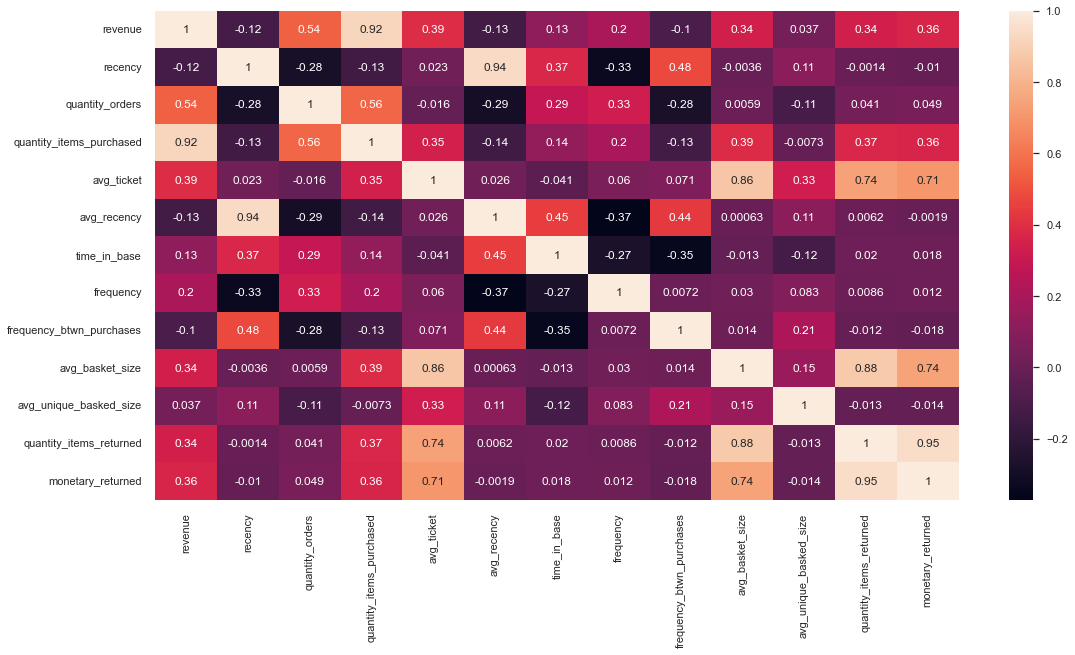

In [51]:
plt.figure(figsize=(18,9))
correlation = df4.drop(columns=['customer_id']).corr(method='pearson')
sns.heatmap(correlation, annot=True)
plt.show()

<Figure size 1080x1080 with 0 Axes>

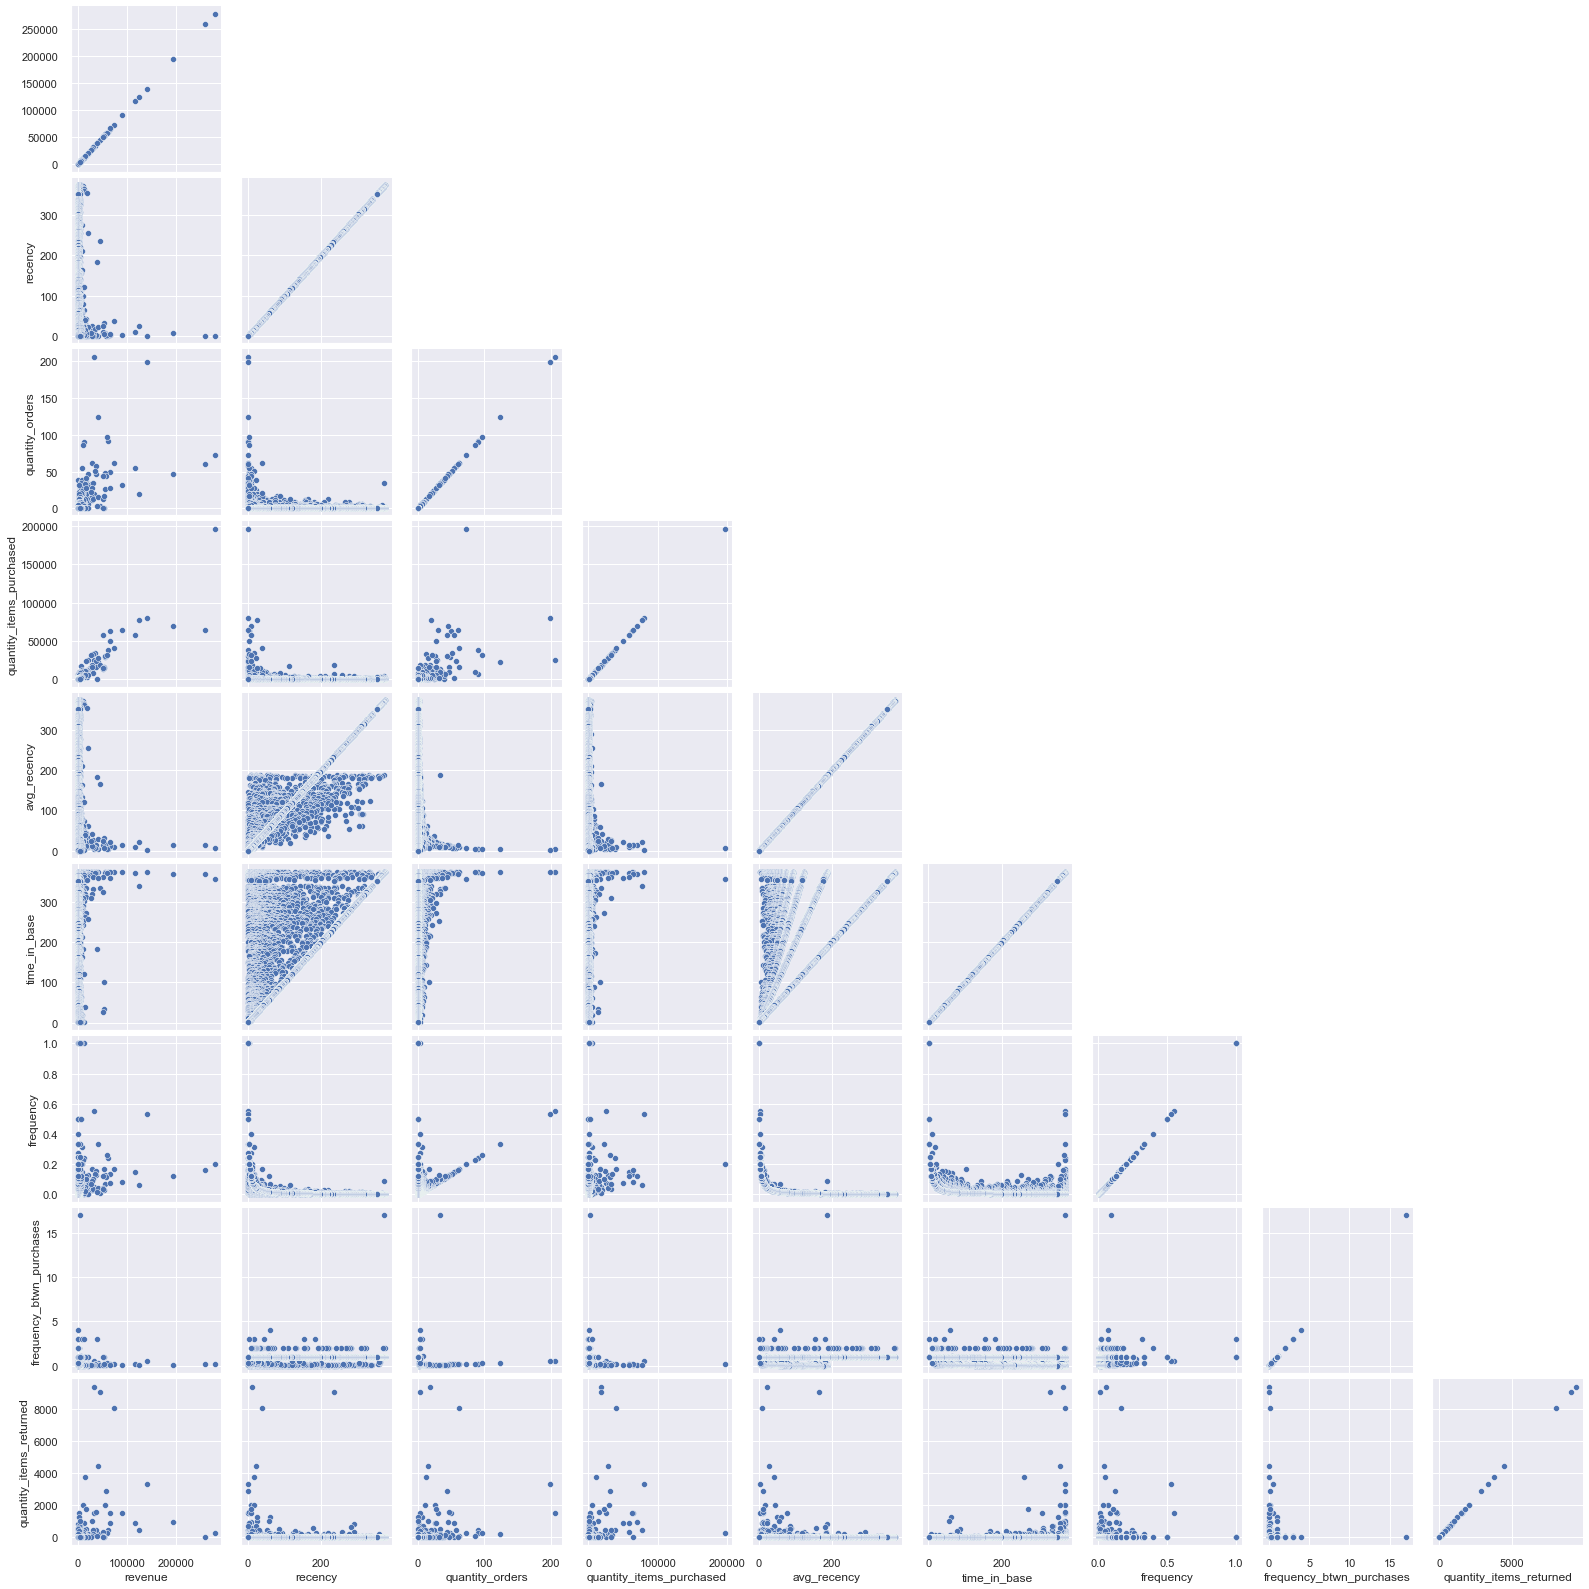

In [127]:
df4 = pd.read_pickle('../datasets/intermediary_data_df4.pkl')
df_pairplot = df4.drop(columns=['customer_id', 'avg_ticket', 'avg_basket_size', 'avg_unique_basked_size', 'monetary_returned'])

plt.figure(figsize=(15,15))
sns.pairplot(df_pairplot, corner=True, diag_kind=None)
plt.show()

- Frequency tem baixa variação 

# 5.0. PASSO 05 - PREPARAÇAO DOS DADOS

In [6]:
df4 = pd.read_pickle('../datasets/intermediary_data_df4.pkl')
df5 = df4.copy()
df5_notscaled = df4.copy()

1. Distribuição normal e não possui outlier: Standard Scaler
2. Distribuição normal e possui outlier: Robust Scaler
3. Distribuição não normal: MinMax Scaler

In [7]:
df5 = df4.copy()

mm = pp.MinMaxScaler()
ss = pp.StandardScaler()
rs = pp.RobustScaler()

df5['revenue'] = mm.fit_transform(df5[['revenue']])
df5['recency'] = mm.fit_transform(df5[['recency']])
df5['quantity_orders'] = mm.fit_transform(df5[['quantity_orders']])
df5['quantity_items_purchased'] = mm.fit_transform(df5[['quantity_items_purchased']])
df5['avg_ticket'] = mm.fit_transform(df5[['avg_ticket']])
df5['avg_recency'] = mm.fit_transform(df5[['avg_recency']])
# assumi ss
df5['time_in_base'] = ss.fit_transform(df5[['time_in_base']])
df5['frequency'] = mm.fit_transform(df5[['frequency']])
df5['frequency_btwn_purchases'] = mm.fit_transform(df5[['frequency_btwn_purchases']])
df5['avg_basket_size'] = mm.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basked_size'] = mm.fit_transform(df5[['avg_unique_basked_size']])
df5['quantity_items_returned'] = mm.fit_transform(df5[['quantity_items_returned']])
df5['monetary_returned'] = mm.fit_transform(df5[['monetary_returned']])

In [66]:
variable = 'monetary_returned'

In [67]:
# Dados Originais
print(f"Min: {df5_notscaled[variable].min()} // Max: {df5_notscaled[variable].max()}")
sns.displot(df5_notscaled[variable]);

Min: 0.0 // Max: 168469.6
Error in callback <function flush_figures at 0x0000024C9D6A0160> (for post_execute):



KeyboardInterrupt


KeyboardInterrupt



In [ ]:
# Dados Normalizados / Rescalados
print(f"Min: {df5[variable].min()} // Max: {df5[variable].max()}")
sns.displot(df5[variable]);

In [ ]:
sns.boxplot(x=variable ,data=df5_notscaled);

# 6.0. PASSO 06 - FEATURE SELECTION

1. Não vou selecionar features que usam a média, porque no final já vou calcular a média do profile todo.
- Removidas: avg_ticket, avg_basket_size, avg_unique_basked_size (falta escolher o avg_recency ou não)
2. Contar o número de ordens e de produtos comprados pode ser redundante, por isso vou remover:
- Removida: quantity_items_purchased (Por enquanto não)
3. Contar o número de produtos devolvidos e o valor monetário devolvido é redundante, por isso vou remover:
- Removida: monetary_returned

In [8]:
cols_select = ['customer_id', 'revenue', 'recency', 'quantity_orders',
       'quantity_items_purchased', 'time_in_base',
       'frequency', 'frequency_btwn_purchases', 'quantity_items_returned']

In [9]:
df6 = df5[cols_select].copy()

# 7.0. PASSO 07 - ESTUDO DO ESPAÇO 

In [10]:
df7 = df6.drop(columns=['customer_id']).copy()
X = df7.copy()

### 4.3.1. PCA

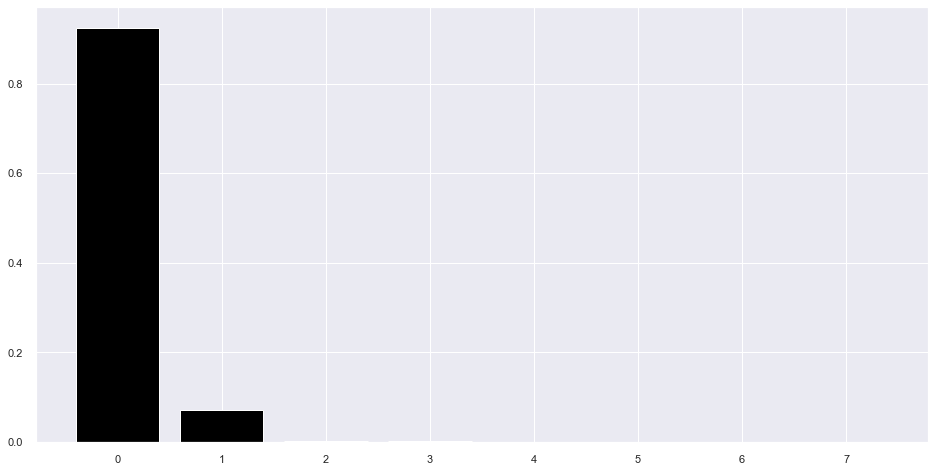

In [11]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

df_pca = pd.DataFrame(principal_components)

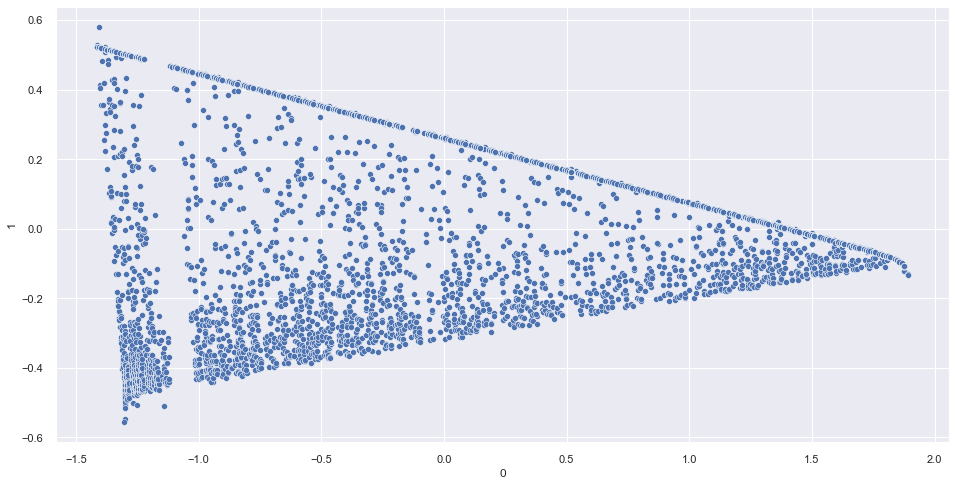

In [12]:
sns.scatterplot(x=0, y=1, data= df_pca);

### 4.3.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

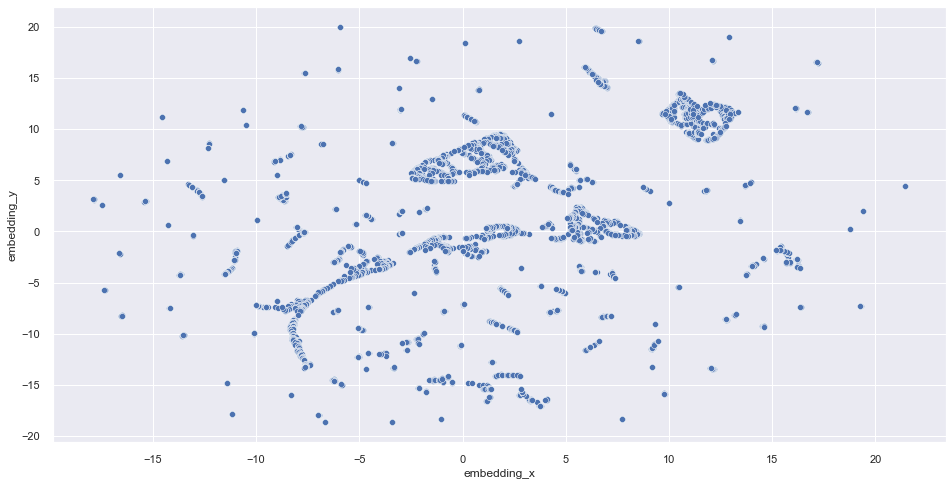

In [13]:
reducer = ump.UMAP(random_state=99) # n_neighbors --> como se representasse um zoom (olhando globalmente)
embedding = reducer.fit_transform(X)

# embedding 
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(data=df_pca, x='embedding_x', y='embedding_y')

# pontos proximos da mesma cor --> na alta dimensionalidade a probabilidade de estarem proximos é alta

### 4.3.3. t-SNE

C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

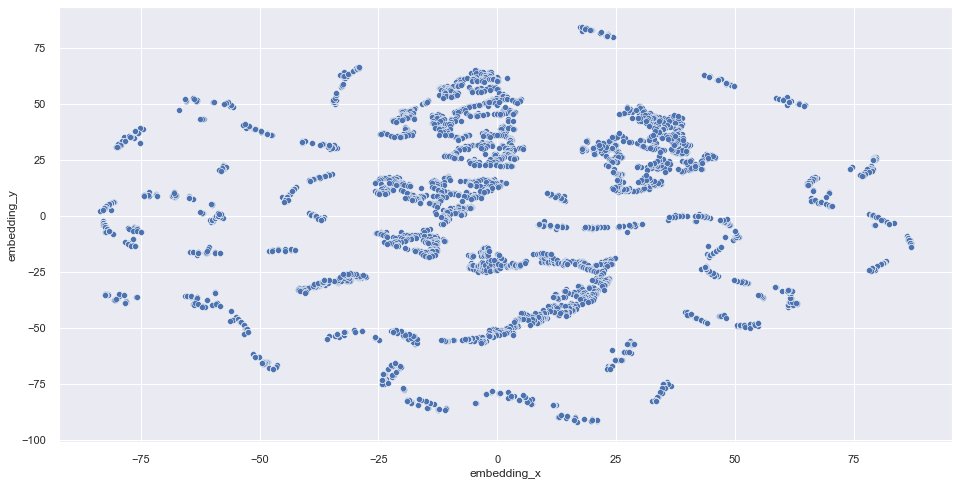

In [14]:
reducer = TSNE(n_components=2 , random_state=99, n_jobs=-1) # n_neighbors --> como se representasse um zoom (olhando globalmente)
embedding = reducer.fit_transform(X)

# embedding 
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(data=df_pca, x='embedding_x', y='embedding_y')

# pontos proximos da mesma cor --> na alta dimensionalidade a probabilidade de estarem proximos é alta

### 4.3.4. Tree-Based Embedding

In [15]:
from sklearn import ensemble as en

In [16]:
# training dataset
X_t = X.drop(columns=['revenue'])
y = X['revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=200, random_state=99)

# model training
rf_model.fit(X_t, y)

# dataframe Leaf
df_leaf = pd.DataFrame(rf_model.apply(X_t))

- Perco explicabildade, porém a solução funciona porque não preciso de explicabilidade como os vizinhos são construidos e sim explicar as variáveis em relação ao clusters
- Ex: Esse cluster em média compra x, tem recencia y, etc

C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

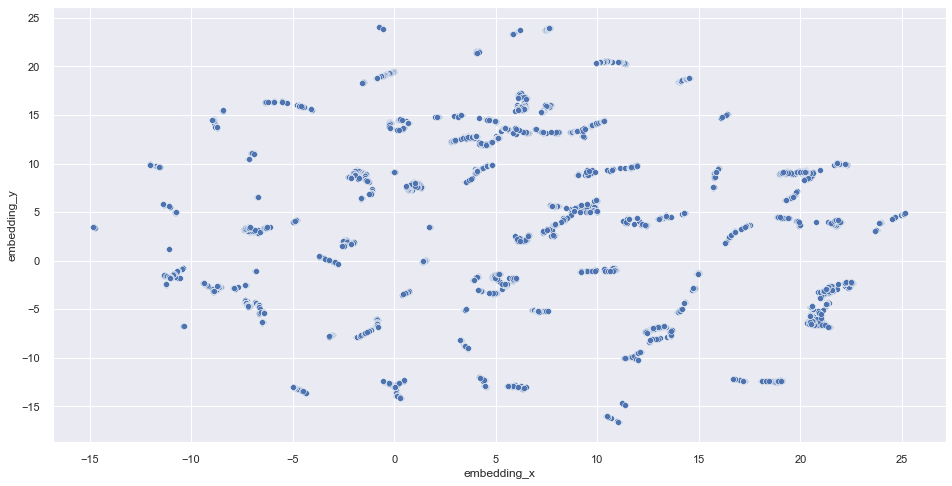

In [20]:
reducer = ump.UMAP(random_state=99) # n_neighbors --> como se representasse um zoom (olhando globalmente)
embedding = reducer.fit_transform(df_leaf)

df_tree_umap = pd.DataFrame()
# embedding 
df_tree_umap['embedding_x'] = embedding[:, 0]
df_tree_umap['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(data=df_tree_umap, x='embedding_x', y='embedding_y')

# pontos proximos da mesma cor --> na alta dimensionalidade a probabilidade de estarem proximos é alta

C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

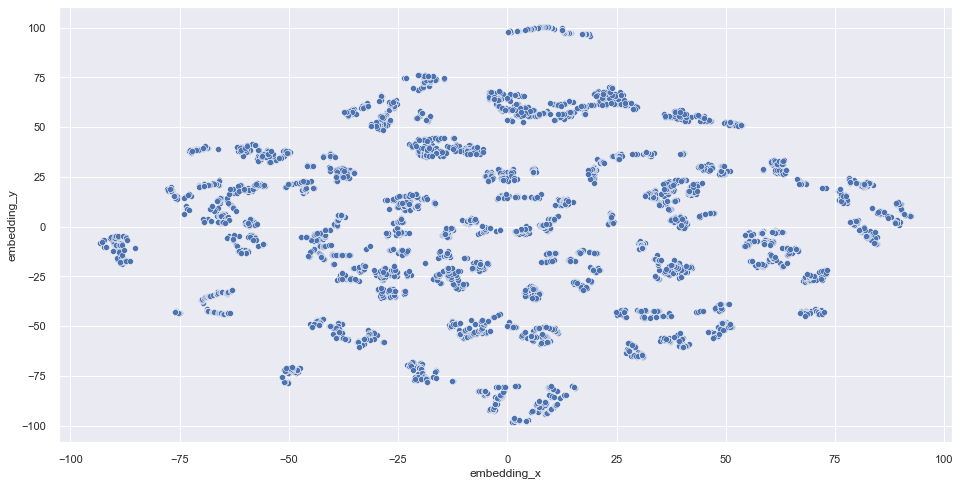

In [18]:
reducer = TSNE(n_components=2 , random_state=99, n_jobs=-1) # n_neighbors --> como se representasse um zoom (olhando globalmente)
embedding = reducer.fit_transform(df_leaf)

df_tree_tsne = pd.DataFrame()
# embedding 
df_tree_tsne['embedding_x'] = embedding[:, 0]
df_tree_tsne['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(data=df_tree_tsne, x='embedding_x', y='embedding_y')

# 7.0. PASSO 07 - FINDING THE NUMBER OF CLUSTERS

HYPERPARAMETER FINE TUNING

Using tree embedding

In [19]:
df7 = df_tree_umap.copy()
X = df7.copy()

NameError: name 'df_tree_umap' is not defined

Using features space

In [90]:
# X = df7.drop(columns=['customer_id'])

In [76]:
clusters = range(2,25)

## 7.1. K-Means

In [77]:
kmeans_sil_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=99)
    
    # model training
    kmeans_model.fit(X)
    
    # model predict
    labels = kmeans_model.predict(X)
    
    # model performance
    kmeans_sil_list.append(m.silhouette_score(X, labels, metric='euclidean'))

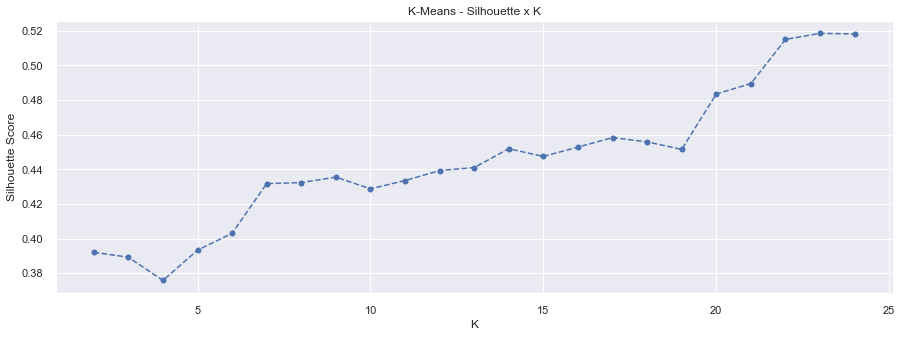

In [78]:
plt.figure(figsize=(15,5))
plt.plot(clusters, kmeans_sil_list, linestyle='--', marker='o')
plt.title('K-Means - Silhouette x K')
plt.ylabel('Silhouette Score')
plt.xlabel('K');

## 7.2. GMM

In [79]:
from sklearn import mixture as mx

In [80]:
gmm_sil_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)
    
    # model training
    gmm_model.fit(X)
    
    # model predict
    labels = gmm_model.predict(X)
    
    # model performance
    gmm_sil_list.append(m.silhouette_score(X, labels, metric='euclidean'))

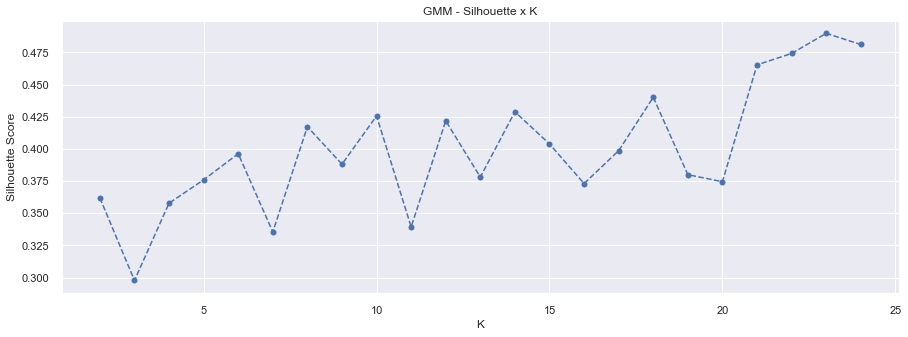

In [81]:
plt.figure(figsize=(15,5))
plt.plot(clusters, gmm_sil_list, linestyle='--', marker='o')
plt.title('GMM - Silhouette x K')
plt.ylabel('Silhouette Score')
plt.xlabel('K');

## 7.3. Hierarchical Clustering

AIC - Ajuste dos dados

BIC - Ajuste dos parametros

In [82]:
from scipy.cluster import hierarchy as hc

In [83]:
# model definition
hc_model = hc.linkage(X, 'ward')

In [84]:
# hc.dendrogram(
#     hc_model,
#     leaf_rotation=90,
#     leaf_font_size=8
# )

# plt.plot()

[]

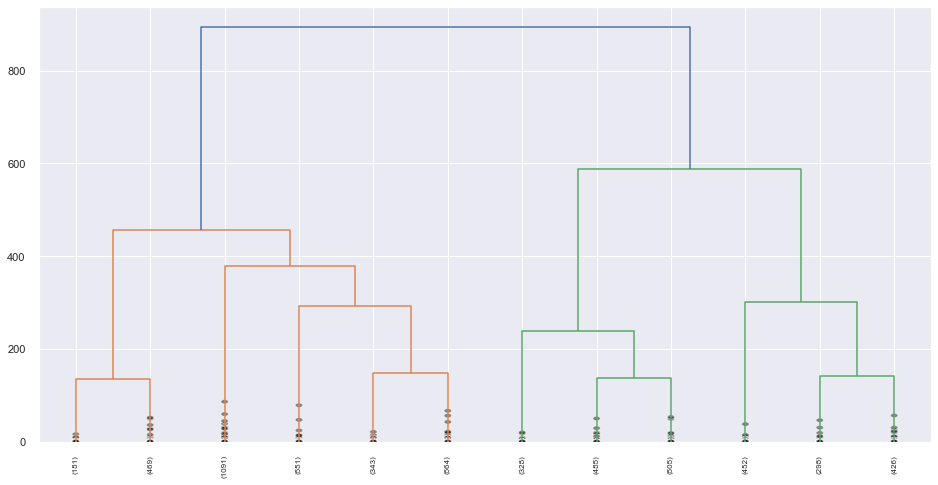

In [85]:
hc.dendrogram(
    hc_model,
    leaf_rotation=90,
    leaf_font_size=8,
    truncate_mode='lastp',
    p=12,
    show_contracted=True
)

plt.plot()

### 7.3. HClustering Silhouette Score

In [86]:
hc_sil_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    hc_sil_list.append(m.silhouette_score(X, labels, metric='euclidean'))

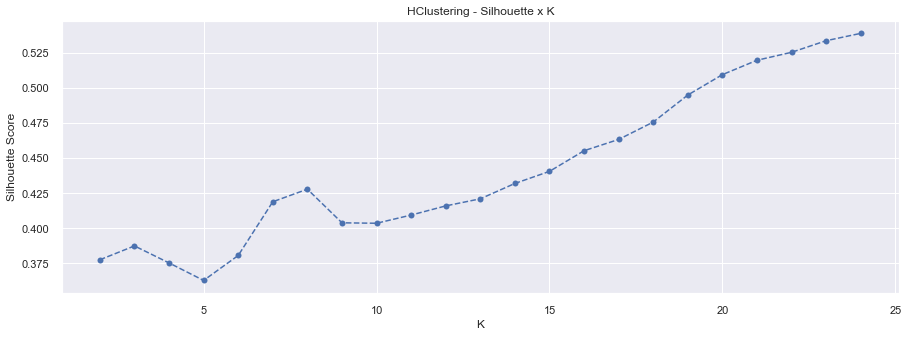

In [87]:
plt.figure(figsize=(15,5))
plt.plot(clusters, hc_sil_list, linestyle='--', marker='o')
plt.title('HClustering - Silhouette x K')
plt.ylabel('Silhouette Score')
plt.xlabel('K');

## 7.4. DBSCAN

In [88]:
dbscan_sil_list = []
eps = 0.06
min_samples = 10

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and predict
labels = dbscan_model.fit_predict(X)

dbscan_sil_list.append(m.silhouette_score(X, labels, metric='euclidean'))

In [89]:
dbscan_sil_list

[0.38316706]

In [ ]:
np.unique(labels)

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [ ]:
plt.plot(distances[5650:]);

In [ ]:
dbscan_sil_list

In [ ]:
dbscan_sil_list_final = dbscan_sil_list.copy()
dbscan_sil_list_final.extend([0, 0, 0, 0, 0])

## 7.5. Results

In [ ]:
df_results = pd.DataFrame({
    'Kmeans':kmeans_sil_list,
    'GMM':gmm_sil_list,
    'HC':hc_sil_list,
    'DBSCAN':dbscan_sil_list_final
}, index=clusters).T

In [ ]:
df_results.style.highlight_max(color='lightgreen', axis=1)

## 7.6. Silhouette Analysis

In [ ]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(25,20)


for k in clusters:
    
    q, mod = divmod(k, 2)
    
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performance
    ss = m.silhouette_score(X, labels, metric='euclidean')
    print(f'For k= {k} // SS= {ss:.2f}')

    sample_silhouette_values = m.silhouette_samples(X, labels)
    
    y_lower=10
    for i in np.unique(labels):

        # select a cluster
        ith_samples_silhouette_values = sample_silhouette_values[labels==i]

        # size of the cluster
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        
        # upper limite
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i/k)

        # sort values
        ith_samples_silhouette_values.sort()

    
        # plot
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        y_lower = y_upper + 10
    
    
    ax[q-1, mod].set_title(f'k={k}')
    # x and y limits
    #ax[q-1, mod].set_xlim([min(sample_silhouette_values) - 0.02, 1])
    ax[q-1, mod].set_xlim([-0.6, 1])
    ax[q-1, mod].set_ylim([0, len(X) + (k+1)*10 ])


# 8.0. PASSO 08 - MODEL TRAINING

## 8.1. K-Means

In [21]:
# model definition
k = 8
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=99)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

In [ ]:
# pickle.dump(kmeans, open('../models/test_kmeans_model.pkl', 'wb'))

kmeans = pickle.load(open('../models/test_kmeans_model.pkl', 'rb'))

# clustering
labels = kmeans.labels_

### 8.1.1. Cluster Validation

In [39]:
# WSS 
print(f'WSS: {kmeans.inertia_:.2f}')

# SS
print(f'SS: {m.silhouette_score(X, labels, metric="euclidean"):.3f}')

WSS: 262.16
SS: 0.479


# 9.0. PASSO 09 - CLUSTER ANALYSIS

In [40]:
df9 = df4[cols_select].copy()
df9['cluster'] = labels
df9.head()

,customer_id,revenue,recency,quantity_orders,quantity_items_purchased,time_in_base,frequency,frequency_btwn_purchases,quantity_items_returned,cluster
0,17850,5391.21,372,34,1733,374,0.090909,17.000000,40,1
1,13047,3232.59,56,9,1390,374,0.024064,0.028302,35,4
2,12583,6705.38,2,15,5028,374,0.040107,0.040323,50,4
3,13748,948.25,95,5,439,374,0.013369,0.017921,0,4
4,15100,876.00,333,3,80,374,0.008021,0.073171,22,1


## 9.1. Visualization Inspection

C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


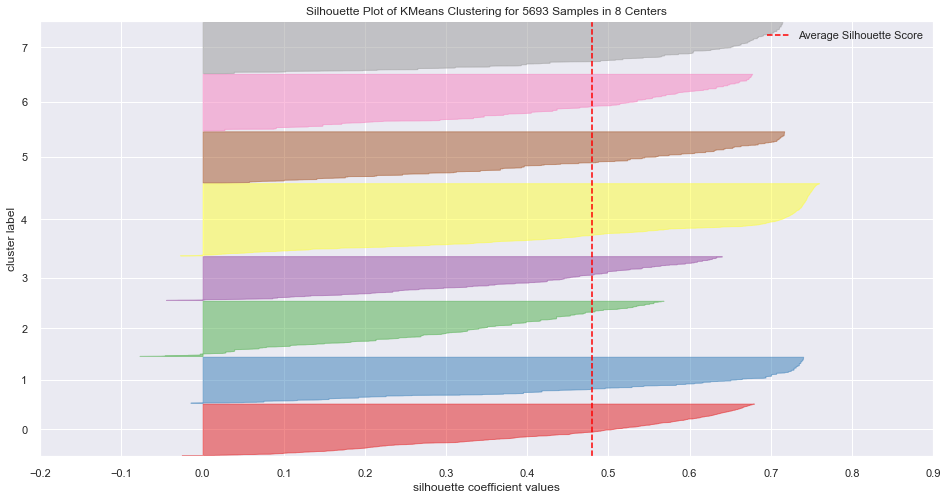

In [24]:
visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

## 9.2. Cluster Profile

In [27]:
# Number of customers
df_profile = pd.DataFrame({'count': df9['cluster'].value_counts(), 
                                    'percent': df9['cluster'].value_counts(normalize=True) * 100})

df_profile.index.name = 'cluster'

df_profile = df_profile.reset_index()

# Average in other metrics
average_metrics_by_cluster = df9.drop(columns=['customer_id']).groupby('cluster').mean().reset_index()


df_profile = df_profile.merge(average_metrics_by_cluster, on='cluster').sort_values('revenue', ascending=False)

df_profile

,cluster,count,percent,revenue,recency,quantity_orders,quantity_items_purchased,time_in_base,frequency,frequency_btwn_purchases,quantity_items_returned
0,4,960,16.862814,5439.390156,36.517708,10.066667,3117.509375,355.932292,0.027965,0.030052,72.498958
3,0,685,12.032320,1986.667489,46.004380,5.113869,1268.134307,275.908029,0.018531,0.021906,24.588321
4,7,683,11.997190,1046.691801,22.726208,1.310395,418.325037,27.819912,0.078826,0.888717,1.619327
6,1,613,10.767609,909.305840,327.347471,1.438825,330.145188,346.611746,0.004130,0.845754,20.296900
2,2,734,12.893027,874.829414,141.970027,2.114441,425.521798,201.698910,0.010435,0.610038,4.677112
1,6,754,13.244335,860.159019,58.282493,1.702918,436.054377,77.446950,0.022410,0.716597,6.716180
7,3,584,10.258212,852.792243,103.162671,1.933219,463.404110,145.488014,0.013216,0.643136,3.304795
5,5,680,11.944493,564.143574,256.332353,1.247059,230.672059,269.307353,0.004637,0.859461,3.704412


In [32]:
# 2 Cluster Insiders
# 1 Cluster More Items
# 3 Cluster Less Days
# 4 Cluster Even More Items
# 0 Cluster More Spend
# 5 Cluster More Items and Money
# 7 Cluster Almost the worst
# 6 Cluster More Everything

In [28]:
for _,linha in df_profile.iterrows():
    print(f"Cluster {linha['cluster']+1:.0f}")
    print(f"Número de clientes: {linha['count']:.0f} ({linha['percent']:.2f}% da base)")
    print(f"Recência em média: {linha['recency']:.2f} dias")
    print(f"Frequência média: {linha['frequency']:.2f} compras")
    print(f"Receita em média: U$ {linha['revenue']:,.2f}")
    print('\n')

Cluster 5
Número de clientes: 960 (16.86% da base)
Recência em média: 36.52 dias
Frequência média: 0.03 compras
Receita em média: U$ 5,439.39


Cluster 1
Número de clientes: 685 (12.03% da base)
Recência em média: 46.00 dias
Frequência média: 0.02 compras
Receita em média: U$ 1,986.67


Cluster 8
Número de clientes: 683 (12.00% da base)
Recência em média: 22.73 dias
Frequência média: 0.08 compras
Receita em média: U$ 1,046.69


Cluster 2
Número de clientes: 613 (10.77% da base)
Recência em média: 327.35 dias
Frequência média: 0.00 compras
Receita em média: U$ 909.31


Cluster 3
Número de clientes: 734 (12.89% da base)
Recência em média: 141.97 dias
Frequência média: 0.01 compras
Receita em média: U$ 874.83


Cluster 7
Número de clientes: 754 (13.24% da base)
Recência em média: 58.28 dias
Frequência média: 0.02 compras
Receita em média: U$ 860.16


Cluster 4
Número de clientes: 584 (10.26% da base)
Recência em média: 103.16 dias
Frequência média: 0.01 compras
Receita em média: U$ 852.79

# 10.0. PASSO 10 - EDA

In [29]:
df10 = df9.copy()

## 10.1. MindMap de Hipóteses

1. Fenômeno
2. Entidades (Cliente, Produto, etc)
3. Características da Entidade( Cliente --> Nome, Salário, Idade, etc)

## 10.2. Hipóteses de Negócio

1. Afirmação
2. Comparação entre variáveis
3. Valor base de comparação

- Cluster insiders é o cluster 4

In [52]:
cluster_insiders = 4
df10['is_insider'] = df10['cluster'].apply(lambda x: 'yes' if x == cluster_insiders else 'no')

### Hipóteses Compra

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.

2. **Os clientes do cluster Insiders possuem um ticket médio 10% maior que os outros clientes.**

3. **Os clientes do cluster Insiders possuem um basket size médio acima de 10 produtos.**

4. **Os clientes do cluster Insiders possuem um volume de compras (produtos) que corresponde a mais de 48% (3x sua representativade) do total de compras.**

5. **Os clientes do cluster Insiders possuem um volume de compras que (faturamento) corresponde a mais de 48% (3x sua representativade) do total de compras.**

6. **Os clientes do cluster Insiders possuem uma taxa devolução abaixo da média da base total de clientes.**

7. **A mediana do faturamento dos clientes do cluster insiders é 20% maior do que a mediana do faturamento dos outros clientes.**

### Hipóteses Cliente

1. 60% dos clientes do cluster insiders são casados.
2. 20% dos clientes do cluster insiders estão na faixa de 24-35 anos.
3. 40% dos clientes do cluster insiders estão dentro do raio de 50KM de um centro de distribuição.
4. 95% dos clientes do cluster insiders são do Reino Unido. 
5. 60% dos clientes do cluster insiders recebem mais de 100 mil anualmente.

### Hipóteses Produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster insiders é 10% maior do que a mediana de todos os preços dos produtos.
3. O percentil do preço dos produtos dos clientes do cluster insiders.
4. O peso médio dos produtos comprados pelos clientes dos cluster insiders é maior que o peso médio dos produtos comprados por outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor que a idade média dos produtos comprados por outros clusters(data de criação).

### Perguntas de Negócio

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
2. Quantos clientes farão parte do grupo?
3. Quais as principais características desses clientes ?
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
7. Quais as condições para uma pessoa ser removida do Insiders ?
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Priorização das Hipóteses

1. Há dados para avaliar?
2. É um insight acionável?
3. Vai de encontro com as perguntas que precisamos responder?

## 10.3. Validação das Hipóteses

### H1. **Os clientes do cluster Insiders possuem um ticket médio 10% maior que os outros clientes.**

In [147]:
df10['ticket_per_order'] = df10['revenue'] / df10['quantity_orders']

df_ticket_by_cluster = df10[['is_insider', 'ticket_per_order']].groupby('is_insider').mean().reset_index()
display(df_ticket_by_cluster)
print(f"Falso, o cluster insiders possui um ticket {df_ticket_by_cluster['ticket_per_order'].pct_change()[1]:.1%} menor do que os outros clientes.")

,is_insider,ticket_per_order
0,no,581.368944
1,yes,419.192793


Falso, o cluster insiders possui um ticket -27.9% menor do que os outros clientes.


### H2. **Os clientes do cluster Insiders possuem um basket size médio acima de 10 produtos.**

In [146]:
df10['avg_basket_size'] = df10['quantity_items_purchased'] / df10['quantity_orders']
print(f"Verdadeiro, o cluster insiders tem um basket size médio de {df10.loc[df10['is_insider'] == 'yes','avg_basket_size'].mean():.0f} produtos.")

Verdadeiro, o cluster insiders tem um basket size médio de 248 produtos.


### H3. **Os clientes do cluster Insiders possuem um volume de compras (produtos) que corresponde a mais de 48% (3x sua representativade) do total de compras.**

In [141]:
df_n_items_by_cluster = df10[['is_insider' ,'quantity_items_purchased']].groupby('is_insider').sum().reset_index()

df_n_items_by_cluster['percent_of_products'] = round((df_n_items_by_cluster['quantity_items_purchased'] / df_n_items_by_cluster['quantity_items_purchased'].sum()), 4)

display(df_n_items_by_cluster)
print(f"Verdadeiro, o cluster insiders correponde a {df_n_items_by_cluster.loc[df_n_items_by_cluster['is_insider'] == 'yes','percent_of_products'].values[0]:.2%} da quantidade de produtos total.")

,is_insider,quantity_items_purchased,percent_of_products
0,no,2425370,0.4476
1,yes,2992809,0.5524


Verdadeiro, o cluster insiders correponde a 55.24% da quantidade de produtos total.


### H4. **Os clientes do cluster Insiders possuem um volume de compras que (faturamento) corresponde a mais de 48% (3x sua representativade) do total de compras.**

In [142]:
df_revenue_per_cluster = df10[['is_insider' ,'revenue']].groupby('is_insider').sum().reset_index()

df_revenue_per_cluster['percent_of_revenue'] = round((df_revenue_per_cluster['revenue'] / df_revenue_per_cluster['revenue'].sum()), 4)

display(df_revenue_per_cluster)
print(f"Verdadeiro, o cluster insiders correponde a {df_revenue_per_cluster.loc[df_revenue_per_cluster['is_insider'] == 'yes','percent_of_revenue'].values[0]:.2%} do volume total de vendas(monetário).")

,is_insider,revenue,percent_of_revenue
0,no,4805495.20,0.4792
1,yes,5221814.55,0.5208


Verdadeiro, o cluster insiders correponde a 52.08% do volume total de vendas(monetário).


### H5. **Os clientes do cluster Insiders possuem uma taxa devolução abaixo da média dos outros clientes.**

In [143]:
df10['return_rate'] = df10['quantity_items_returned'] / df10['quantity_items_purchased'] 

df_return_rate_by_cluster = df10[['is_insider' ,'return_rate']].groupby('is_insider').mean().reset_index()

display(df_return_rate_by_cluster)

print(f"Falso, o cluster insiders possui uma taxa de devolução acima da média do outros outros clientes.")

,is_insider,return_rate
0,no,0.012367
1,yes,0.016440


Falso, o cluster insiders possui uma taxa de devolução acima da média do outros outros clientes.


### H6. **A mediana do faturamento dos clientes do cluster insiders é 20% maior do que a mediana do faturamento dos outros clientes.**

In [145]:
df_median_by_cluster = df10[['is_insider' ,'revenue']].groupby('is_insider').median().reset_index()

display(aux)
print(f"Verdadeiro, o cluster insiders possui a mediana {df_median_by_cluster['revenue'].pct_change()[1]:.1%} maior do que os outros clientes.")

,is_insider,revenue
0,no,465.680
1,yes,2082.015


Verdadeiro, o cluster insiders possui a mediana 347.1% maior do que os outros clientes.


## 10.4. Respondendo Perguntas de Negócio

### 1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

In [149]:
df10.loc[df10['is_insider'] == 'yes', 'customer_id'].head()

1    13047
2    12583
3    13748
5    15291
6    14688
Name: customer_id, dtype: int64

### 2. Quantos clientes farão parte do grupo?

In [178]:
line_insiders = df_profile.loc[df_profile['cluster'] == cluster_insiders]
print(f"Farão parte do cluster insiders: {line_insiders['count'].values[0]} clientes ({line_insiders['percent'].values[0]:.2f}% do total).")

Farão parte do cluster insiders: 960 clientes (16.86% do total).


### 3. Quais as principais características desses clientes ?

In [175]:
line_insiders.drop(columns=['cluster'])

,count,percent,revenue,recency,quantity_orders,quantity_items_purchased,time_in_base,frequency,frequency_btwn_purchases,quantity_items_returned
0,960,16.862814,5439.390156,36.517708,10.066667,3117.509375,355.932292,0.027965,0.030052,72.498958


### 4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

In [177]:
df_revenue_per_cluster = df10[['is_insider' ,'revenue']].groupby('is_insider').sum().reset_index()

df_revenue_per_cluster['percent_of_revenue'] = round((df_revenue_per_cluster['revenue'] / df_revenue_per_cluster['revenue'].sum()), 4)

# display(df_revenue_per_cluster)
print(f"O cluster insiders correponde a {df_revenue_per_cluster.loc[df_revenue_per_cluster['is_insider'] == 'yes','percent_of_revenue'].values[0]:.2%} do volume total de vendas(monetário).")

O cluster insiders correponde a 52.08% do volume total de vendas(monetário).


### 5. Qual a expectativa de faturamento desse grupo para os próximos meses ?

In [190]:
df10.iloc[766]

customer_id                    15512
revenue                        121.0
recency                          155
quantity_orders                    2
quantity_items_purchased          68
time_in_base                     360
frequency                   0.005556
frequency_btwn_purchases    0.009756
quantity_items_returned            0
cluster                            4
ticket_per_order                60.5
is_insider                       yes
avg_basket_size                 34.0
return_rate                      0.0
Name: 766, dtype: object

In [184]:
# OFF TOPIC --> Intervalos de confiança
from scipy import stats as st

df_insiders = df10.loc[df10['cluster'] == cluster_insiders, 'revenue']

# Via Bootstrap --> Amostras com repetição
st.t.interval(alpha=0.95,
             df=len(df_insiders)-1,
             loc=np.mean(df_insiders),
             scale=st.sem(df_insiders))

(4349.0994281744115, 6529.680884325588)

### 6. Quais as condições para uma pessoa ser elegível ao Insiders ?

### 7. Quais as condições para uma pessoa ser removida do Insiders ?

### 8. Qual a garantia que o programa Insiders é melhor que o restante da base ?

### 9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

# 11.0. PASSO 11 - DEPLOY TO PRODUCTION